In [3]:
import torch
from PIL import Image
import PIL
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torch.nn import functional as f
import clip

from diffusers import StableDiffusionImg2ImgPipeline
from diffusers.utils import (
    PIL_INTERPOLATION,
)
import diffusers
from torchvision.utils import make_grid
import torchvision

In [5]:
# load the pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16, safety_checker=None
).to(device)

# uncomment this if you have troubles with available memory
# pipe.enable_attention_slicing()

model, preprocess = clip.load("ViT-L/14", device=device)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/home/sharfikeg/anaconda3/envs/myenv/lib/python3.9/site-packages/clip/clip.py:57: UserWarning: /home/sharfikeg/.cache/clip/ViT-L-14.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")
100%|███████████████████████████████████████| 890M/890M [01:49<00:00, 8.48MiB/s]


In [3]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
def clip_classify(images, prompts, model):
    
    text_embeddings = model.encode_text(prompts)
    images_embeddings = images

    dots = (images_embeddings @ text_embeddings.T)
    # cosines = dots / torch.linalg.norm(images_embeddings, dim=1)[:, None] / torch.linalg.norm(text_embeddings, dim=1)
    return f.softmax(dots, dim=1)

In [43]:
def preprocess1(image):
    if isinstance(image, torch.Tensor):
        return image
    elif isinstance(image, PIL.Image.Image):
        image = [image]

    if isinstance(image[0], PIL.Image.Image):
        w, h = image[0].size
        w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
        print(w, h)

        image = [np.array(i.resize((w, h), resample=PIL_INTERPOLATION["lanczos"]))[None, :] for i in image]
        image = np.concatenate(image, axis=0)
        image = np.array(image).astype(np.float32) / 255.0
        image = image.transpose(0, 3, 1, 2)
        image = 2.0 * image - 1.0
        image = torch.from_numpy(image)
    elif isinstance(image[0], torch.Tensor):
        image = torch.cat(image, dim=0)
    return image

448 448


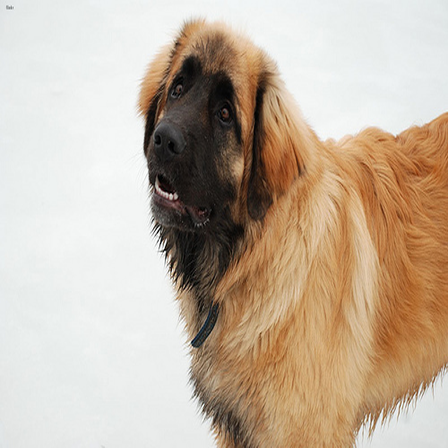

In [44]:
init_image = Image.open('/home/sharfikeg/my_files/oxford_pets/_/Leonberger/2.jpg').resize((448,448), PIL.Image.Resampling.LANCZOS)
init_image_tensor = preprocess1(init_image)
# print(init_image_tensor.shape)
init_image

In [65]:

prompt = [
    'an Abyssinian',
    'an American Bulldog',
    'an American Pit Bull Terrier',
    'a Basset Hound',
    'a Beagle',
    'a Bengal',
    'a Birman',
    'a Bombay',
    'a Boxer',
    'a British Shorthair',
    'a Chihuahua','a Egyptian Mau',
    'an English Cocker Spaniel','an English Setter',
    'a German Shorthaired','a Great Pyrenees',
    'a Havanese','a Japanese Chin',
    'a Keeshond','a Leonberger',
    'a Maine Coon','a Miniature Pinscher',
    'a Newfoundland','a Persian',
    'a Pomeranian','a Pug','a Ragdoll',
    'a Russian Blue','a Saint Bernard',
    'a Samoyed','a Scottish Terrier',
    'a Shiba Inu','a Siamese','a Sphynx',
    'a Staffordshire Bull Terrier','a Wheaten Terrier','a Yorkshire Terrier']

prompts = [
    f'A photo of {label}, type of pet.' for label in prompt
]
prompts_clip = [
    f'{label} pet' for label in prompt
]
images = pipe(prompt=prompts, image=init_image, strength=0.6, guidance_scale=7.5, num_inference_steps=100, num_images_per_prompt=1).images

# images

/home/sharfikeg/anaconda3/envs/myenv/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:483: FutureWarning: You have passed 37 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/60 [00:00<?, ?it/s]

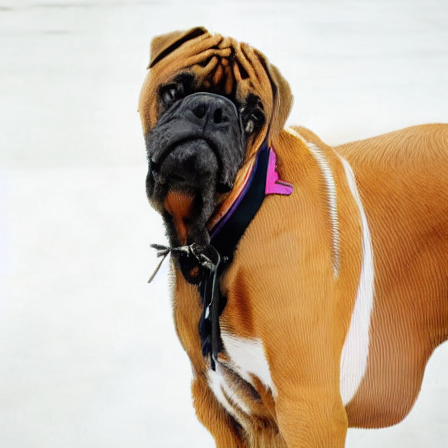

In [66]:
images[8]

In [67]:
# make grid from the input images
# set nrow=3, and padding=25
answer = 1
images_tensor_list = [torchvision.transforms.ToTensor()(image) for image in images ]
if answer:
    images_tensor_list_stacked = torch.stack(images_tensor_list, dim=0)
    results = torch.linalg.norm(images_tensor_list_stacked.flatten(start_dim=1, end_dim=-1)-init_image_tensor.flatten(start_dim=1, end_dim=-1), dim=1)
    print(f"pred: {prompt[torch.argmin(results).item()]}")

    init_clip = model.encode_image(preprocess(init_image).unsqueeze(0).to(device))
    clip_results = clip_classify(init_clip, prompts=clip.tokenize(prompts_clip).to(device), model=model)

    recons_clip=model.encode_image( torch.stack([preprocess(image) for image in images], dim=0).to(device))
    results = torch.linalg.norm(recons_clip-init_clip, dim=1)
    print(f'clip decision: {prompt[torch.argmax(clip_results).item()]}')
    print(f'diffclip decision: {prompt[torch.argmin(results).item()]}')
    print(f'top-3: 1: {prompt[torch.sort(results)[1][0]]}, 2: {prompt[torch.sort(results)[1][1]]}, 3: 2: {prompt[torch.sort(results)[1][2]]}\nDiff: {torch.sort(results)[0][1]-torch.sort(results)[0][0]}')
else:
    Grid = make_grid(images_tensor_list[1], nrow=len(prompt))

    # display result
    show(Grid)


pred: an Abyssinian
clip decision: a Leonberger
diffclip decision: a Great Pyrenees
top-3: 1: a Great Pyrenees, 2: a Leonberger, 3: 2: a Saint Bernard
Diff: 0.7109375
